<a href="https://colab.research.google.com/github/mbrimmer/W207_Assignments/blob/master/matthew_brimmer_p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [0]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print ('training label shape:', train_labels.shape)
print ('test label shape:', test_labels.shape)
print ('dev label shape:', dev_labels.shape)
print ('labels names:', newsgroups_train.target_names)

('training label shape:', (2034,))
('test label shape:', (677,))
('dev label shape:', (676,))
('labels names:', ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc'])


(1) For each of the first 5 training examples, print the text of the message along with the label.

In [3]:
def P1(num_examples=5):
  ## STUDENT START ###
  for i in range(num_examples):
    print("\n****************\nExample: {}, \n****\nText={}, \n****\nLabel={}".
          format(i, train_data[i], 
                 list(newsgroups_train.target_names)[train_labels[i]]))
  ## STUDENT END ###

P1()


****************
Example: 0, 
****
Text=Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych, 
****
Label=comp.graphics

****************
Example: 1, 
****
Text=

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been de

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [0]:
def print_nth_feature_string(feature_row, feature_list):
  vals = [feature_list[i] for i in feature_row.nonzero()[1]]
  vals.sort()
  return vals

In [5]:
def P2():
  ### STUDENT START ###
  vectorizer = CountVectorizer()
  X = vectorizer.fit_transform(train_data)
  print("******** Question a ********")
  print("Size of corpus (Vocabulary): {} words".format(X.shape[1]))
#   print(len(vectorizer.get_feature_names()))
  print("Average # Non-Zero Features Per Examples: {}".\
        format( X.getnnz(axis=1).mean().round(1) ))
  print("Fraction of entries in matrix non-zero: {}".\
        format((float(X.nnz) / (X.shape[0]*X.shape[1]))))
  
  print("\n******** Question b ********")
  print('0th feature string')
  print(print_nth_feature_string(X.getrow(0), 
                           list(vectorizer.get_feature_names())))
  print('Last feature string')
  print(print_nth_feature_string(X.getrow(-1), 
                           list(vectorizer.get_feature_names())))
  print("Note, Last document was null -- no values")
  
  print("\n******** Question c ********")
  new_vocab =  ["atheism", "graphics", "space", "religion"]
  new_vocab_cols = [indx for indx, i in 
                    enumerate(list(vectorizer.get_feature_names())) 
                    if i in new_vocab]
  print("Cols: {}".format(new_vocab_cols))
  #TODO - make this more efficient
  new_X = X.todense()[:,new_vocab_cols]
  print("New matrix shape: {}".format(new_X.shape))
#   print(new_X)
  print("Average number of non-zero features per example: {}".\
        format( (new_X>0).sum(axis=1).mean() ))
  
  print("\n******** Question d ********")
  vectorizer_partD = CountVectorizer(ngram_range=(2,3), analyzer='word')
  X_partD = vectorizer_partD.fit_transform(train_data)
  print("Size of corpus (Vocabulary (ngrams)): {} words".\
        format(X_partD.shape[1]))
  print("Note above: size of vocabulary dramatically increases")
  
  print("\n******** Question e ********")
  vectorizer_partE = CountVectorizer(min_df=10)
  X_partE = vectorizer_partE.fit_transform(train_data)
  print("Size of corpus (Vocabulary) with min 10 documents: {} words".\
        format(X_partE.shape[1]))
  
  print("\n******** Question f ********")
  vectorizer_dev = CountVectorizer()
  X_dev = vectorizer_dev.fit_transform(dev_data)
  dev_labels = set(list(vectorizer_dev.get_feature_names()))
  train_labels = set(list(vectorizer.get_feature_names()))
  print("Words in Dev Vocab: {}".format(len(dev_labels)))
  print("Words in Train Vocab: {}".format(len(train_labels)))
  print("Words in Dev Vocab but not Train: {}".\
        format(len(dev_labels - train_labels)))
  print("Fraction of unique Dev Words missing from Train: {}".\
        format( float(len(dev_labels - train_labels)) / len(dev_labels)))

  ### STUDENT END ###
P2()

******** Question a ********
Size of corpus (Vocabulary): 26879 words
Average # Non-Zero Features Per Examples: 96.7
Fraction of entries in matrix non-zero: 0.00359782722696

******** Question b ********
0th feature string
[u'3ds', u'able', u'about', u'after', u'all', u'and', u'anyone', u'are', u'available', u'be', u'but', u'carefully', u'cel', u'default', u'does', u'explicitly', u'file', u'for', u'format', u'from', u'given', u'have', u'hi', u'if', u'in', u'information', u'is', u'it', u'know', u'like', u'manual', u'mapping', u'model', u'not', u'nothing', u'noticed', u'only', u'orientation', u'planes', u'position', u'positioned', u'positions', u'preserved', u'prj', u'read', u'reload', u'restarting', u'rule', u'rules', u'rych', u'said', u'save', u'saving', u'somewhere', u'stored', u'texture', u'that', u'the', u'their', u'they', u'this', u'to', u've', u'when', u'why', u'with', u'you', u'your']
Last feature string
[]
Note, Last document was null -- no values

******** Question c ********
C

(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

In [13]:
def P3():
  ### STUDENT START ###
  vectorizer = CountVectorizer()
  X = vectorizer.fit_transform(train_data)
  
  knn_param_grid = {'n_neighbors': [2, 4, 8, 16, 32]}
#   knn_param_grid = {'n_neighbors': [3,4]}
  nb_param_grid = {'alpha': [0.0, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
#   nb_param_grid = {'alpha': [0.001, 0.01]}
  log_param_grid = {'C': [0.00001, 0.001, 0.01, 0.1, 0.5, 1.0]}
#   log_param_grid = {'C': [0.001, 0.01]}

  # FIT KNN
  knn=KNeighborsClassifier()
  knn_grid = GridSearchCV(knn, knn_param_grid, cv=5, scoring='f1_micro', 
                      refit=True, verbose=0)  
  knn_grid.fit(X, train_labels)
  
  # FIT NB
  nb=MultinomialNB()
  nb_grid = GridSearchCV(nb, nb_param_grid, cv=5, scoring='f1_micro', 
                      refit=True, verbose=0)  
  nb_grid.fit(X, train_labels)
  
  # LOG Reg
  logreg=LogisticRegression(penalty='l2', multi_class='auto')
  logreg_grid = GridSearchCV(logreg, log_param_grid, cv=5, scoring='f1_micro', 
                      refit=True, verbose=0)  
  logreg_grid.fit(X, train_labels)

  
  print("******** Question a ********")
  print('Best KNN Params: {}'.format(knn_grid.best_params_))
  print('Best KNN F1: {}'.format(knn_grid.best_score_))
  
  print('Best NB Params: {}'.format(nb_grid.best_params_))
  print('Best NB F1: {}'.format(nb_grid.best_score_))
  
  print('Best Logit Regression Params: {}'.format(logreg_grid.best_params_))
  print('Best Logit Regression F1: {}'.format(logreg_grid.best_score_))

  print("Looking at logistic regression coefs now")
  # don't believe I have access to coefs_ with grid serach, but will rerun
  # without grid search

  
  clf_lst = [LogisticRegression(penalty='l2', multi_class='auto', C = c) for 
    c in log_param_grid['C']]
  
  
  # do for eaach value of C
  for i, clf in enumerate(clf_lst):
    clf.fit(X, train_labels)

    print("C val: {}".format(log_param_grid['C'][i]))
    # calc sum of squares of coef
    
    # for each class
    for j in range(len(categories)):
      sum_squares = 0
      for k in clf.coef_[j]:
        sum_squares += k **2
      print(sum_squares)

  ### STUDENT END ###
P3()

/usr/local/lib/python2.7/dist-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


******** Question a ********
Best KNN Params: {'n_neighbors': 8}
Best KNN F1: 0.43215339233
Best NB Params: {'alpha': 0.01}
Best NB F1: 0.828416912488
Best Logit Regression Params: {'C': 0.5}
Best Logit Regression F1: 0.778269419862
Looking at logistic regression coefs now
C val: 1e-05
0.0003135077976546245
0.0006101265330067586
0.0003848293888889098
0.0003414566121614291
C val: 0.001
0.1650934517100945
0.2009527469058052
0.18067093752539456
0.18724278437842412
C val: 0.01
2.5414724178403385
2.939709368365755
2.862468667787995
2.250026673882611
C val: 0.1
27.13034694888936
24.65563866728689
27.458834803055403
23.025168379795062
C val: 0.5
102.62295815695386
83.1170631651981
99.02625664392062
89.01107674507814
C val: 1.0
166.90926443149039
130.8855026830024
157.9612983459227
145.72854664270912


ANSWER:<p>
a. **Why doesn't nearest neighbors work well for this problem?**
The distance metric we are using to calculate "nearest" doesn't make sense for this text classification so it's no wonder that the usage of it is not helpful.
  
b. **Any ideas why logistic regression doesn't work as well as Naive Bayes?**
It's not a linear problem. The naive bayes model is teasing out some non-linearity that the logistic regression can't.
  
c. Logistic regression estimates a weight vector for each class, which you can access with the coef_ attribute. **Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.** -- output is above but as value of C increases, (less regularization), coefficient values are higher

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [7]:
# import one package -- I know documentation says not to do so, but this
# would be native in python3 but top section written for python2
# only purpose is a few options with print to not include newline

from __future__ import print_function

def P4():
  ### STUDENT START ###
  vectorizer = CountVectorizer()
  X = vectorizer.fit_transform(train_data)
  
  logit_clf = LogisticRegression(penalty='l1', C=0.5)
  logit_clf.fit(X, train_labels)
  
  # Get top features with the largest weights for each label
  
  all_feature_indx = []
  for i in range(0,len(categories)):
    indx = logit_clf.coef_[i].argsort()[-5:][::-1]
    cols = [vectorizer.get_feature_names()[j] for j in indx]
    vals = [logit_clf.coef_[i][j] for j in indx]
#     print("Indexes: {}".format(indx))
#     print("Columns: {}".format(cols))
#     print("Values: {}".format(vals))
    # store features
    all_feature_indx.extend(indx)
  
  
  # Now should have alal the indexes of columns in list -- can produce table
  for r in ['Feature']+categories:
    print(r + "         ", end='')
  
  
  for k in all_feature_indx:
    print("\n{}".format(vectorizer.get_feature_names()[k]), end='')
    # if short name, add extra tab
    if len(vectorizer.get_feature_names()[k]) < 7:
      print("\t", end='')
    print("\t", end='')
    for i,r in enumerate(categories):
      print("{}".format(logit_clf.coef_[i][k].round(3)), end='')
      print("\t"*3, end='')
    
    
  print("\n\n******** Now with bi-grams ********\n")

  # now do the same with bi-grams
  vectorizer_bigram = CountVectorizer(ngram_range=(2,2), analyzer='word')
  X_bigram = vectorizer_bigram.fit_transform(train_data)
  
  logit_bigram_clf = LogisticRegression(penalty='l1', C=0.5)
  logit_bigram_clf.fit(X, train_labels)
  
  bg_all_feature_indx = []
  for i in range(0,len(categories)):
    bg_indx = logit_bigram_clf.coef_[i].argsort()[-5:][::-1]
    bg_cols = [vectorizer_bigram.get_feature_names()[j] for j in bg_indx]
    bg_vals = [logit_bigram_clf.coef_[i][j] for j in bg_indx]
#     print("Indexes: {}".format(bg_indx))
#     print("Columns: {}".format(bg_cols))
#     print("Values: {}".format(bg_vals))
    # store features
    bg_all_feature_indx.extend(bg_indx)
  
  
  # Now should have alal the indexes of columns in list -- can produce table
  for r in ['Feature']+categories:
    print(r + "         ", end='')
  
  
  for k in bg_all_feature_indx:
    print("\n{}".format(vectorizer_bigram.get_feature_names()[k]), end='')
    # if short name, add extra tab
    if len(vectorizer_bigram.get_feature_names()[k]) < 6:
      print("\t", end='')
    if len(vectorizer_bigram.get_feature_names()[k]) < 16:
      print("\t", end='')

    print("\t", end='')
    for i,r in enumerate(categories):
      print("{}".format(logit_bigram_clf.coef_[i][k].round(3)), end='')
      print("\t"*3, end='')

  ### STUDENT END ###
P4()

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Feature         alt.atheism         talk.religion.misc         comp.graphics         sci.space         
tek		2.288			0.0			0.0			-0.3			
bobby		2.041			0.0			-0.363			-0.416			
atheists	1.368			0.0			0.0			-0.878			
cobb		1.358			0.0			0.0			0.0			
tells		1.301			0.0			0.0			-0.475			
graphics	-1.152			2.701			-2.329			-0.943			
3d		-0.035			2.133			-0.869			-0.254			
file		-0.24			1.701			-1.137			-0.479			
image		-0.697			1.586			-0.73			-0.229			
68070		0.0			1.53			0.0			0.0			
space		-1.591			-0.802			2.563			-2.115			
orbit		-0.376			-0.727			2.409			-0.746			
spacecraft	-0.238			-0.229			1.732			0.0			
launch		-0.305			-0.289			1.596			-0.081			
23		0.0			0.0			1.548			0.0			
blood		-0.755			0.0			0.0			2.026			
fbi		0.0			0.0			-0.396			1.86			
christians	-0.877			-0.021			-0.378			1.359			
order		-1.116			0.0			0.0			1.276			
christ		-0.448			0.0			0.0			1.187			

******** Now with bi-grams ********

Feature         alt.atheism         talk.religion.misc         comp.graphics 

ANSWER: I wouldn't say that there are surprising features, but there are some interesting ones. It's notable that there are so many with numbers. This may be something we may want to use a regex to collapse the grams that are just numbers into single numeric grams. There are a few grams like "all then" that would be good to omit as stop words in the future.<p>
  
  Note: sorry my tables aren't perfectly straight -- I would typically just import pandas and use that functionality, but that's against the importing rules at top.

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [12]:
def empty_preprocessor(s):
   return s

def better_preprocessor(s):
  ### STUDENT START ###
  # convert all to lower
  s = s.lower()
  
  # standardize conjunctions
  s = re.sub(r"what's", "what is ", s)
  s = re.sub(r"\'s", " ", s)
  s = re.sub(r"\'ve", " have ", s)
  s = re.sub(r"can't", "can not ", s)
  s = re.sub(r"i'm", "i am ", s)
  s = re.sub(r"\'re", " are ", s)
  s = s.strip(' ')
  return s
  ### STUDENT END ###

stop_words = ['as', 'its', "it's", 'all', 'then', 'and', 'hers', 
              'between', 'yourself', 'but', 'again', 'there', 'about', 
              'once', 'during', 'out', 'very', 'having', 'with', 'they', 
              'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such',
              'into', 'of', 'most', 'itself', 'other', 'off', 'is', 'as', 'am', 
              'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves',
              'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through']


def P5():
  ### STUDENT START ###
  
  # version 1 - empty preprocessor
  vectorizer_base = CountVectorizer(preprocessor=empty_preprocessor)
  X = vectorizer_base.fit_transform(train_data)
  
  print('Size of Empty Vocabulary: {}'.format(X.shape[1]))
  logit_clf = LogisticRegression(penalty='l1', C=0.5, multi_class='auto')
  logit_clf.fit(X, train_labels)
  
  X_test = vectorizer_base.transform(test_data)
  y_pred = logit_clf.predict(X_test)
  f1 = metrics.f1_score(test_labels, y_pred, average='micro')
  print("f1_base: ", f1.round(2))
  
  # version 2 - custom preprocessor
  vectorizer_imp = CountVectorizer(preprocessor=better_preprocessor, 
                               stop_words=stop_words)
  X = vectorizer_imp.fit_transform(train_data)
  
  print('Size of Better Vocabulary: {}'.format(X.shape[1]))
  logit_clf = LogisticRegression(penalty='l1', C=0.5, multi_class='auto')
  logit_clf.fit(X, train_labels)
  
  
  
  X_test = vectorizer_imp.transform(test_data)
  y_pred = logit_clf.predict(X_test)
  f1 = metrics.f1_score(test_labels, y_pred, average='micro')
  print("f1_base: ", f1.round(2))
#   f1_score(y_true, y_pred, average='macro') 
  ### STUDENT END ###

P5()

Size of Empty Vocabulary: 33291
f1_base:  0.71
Size of Better Vocabulary: 26856
f1_base:  0.73


Above: Reduced size of dictionary by 6435 words

(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

Number nonzero coefs using L1 (all classes): 368
Number nonzero coefs using L2 (all classes): 107516
** Plot accuracy of the re-trained model vs. vocabulary size **


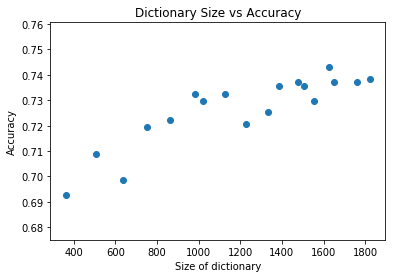

In [9]:
def P6():
  
  # Keep this random seed here to make comparison easier.
  np.random.seed(0)

  ### STUDENT START ###
  
#   print("**Part 1 - Train using L1 penalty & count non-zero learned weights**")
  vectorizer = CountVectorizer()
  X = vectorizer.fit_transform(train_data)
  
  logit_clf = LogisticRegression(penalty='l1', C=0.1, tol=0.01)
  logit_clf.fit(X, train_labels)
  
  
  nNon_zero = 0
  keep_word_vector = np.zeros(X.shape[1])
  keep_word_index_list = []
  
  # for each class
  for j in range(len(categories)):
    for indx,k in enumerate(logit_clf.coef_[j]):
      if abs(k)>0:
        nNon_zero+=1
        keep_word_vector[indx]=1
        keep_word_index_list.append(indx)
        
  print("Number nonzero coefs using L1 (all classes): {}".format(nNon_zero))
  
  # now compare to what this would have been with L2
#   print("**Non-Zero size (what would have been with L2) **")
  logitL2_clf = LogisticRegression(penalty='l2', C=0.1, tol=0.01)
  logitL2_clf.fit(X, train_labels)
  
  nNon_zeroL2 = 0
  # for each class
  for j in range(len(categories)):
    for indx,k in enumerate(logitL2_clf.coef_[j]):
      if abs(k)>0:
        nNon_zeroL2+=1
        
  print("Number nonzero coefs using L2 (all classes): {}".format(nNon_zeroL2))
  
#   print("**Part 2 - Reduce size of vocab and re-train model using L2**")
  print("** Plot accuracy of the re-trained model vs. vocabulary size **")
  
  def find_len_accuracy(X, y, c):
    ''' uses L1 regularization and C value to find non-zero parameters
    to determine vocabulary from training data, 
    then fits model with L2 to this and calculates accuracy based on test data
    '''
    
    l_clf = LogisticRegression(penalty='l1', C=c, tol=0.01)
    l_clf.fit(X, y)
    
    nNon_zero = 0
    keep_word_vector = np.zeros(X.shape[1])
    keep_word_index_list = []

    # for each class
    for j in range(len(categories)):
      for indx,k in enumerate(l_clf.coef_[j]):
        if abs(k)>0:
          nNon_zero+=1
          keep_word_vector[indx]=1
          keep_word_index_list.append(indx)
    
    X2 = X[:,list(set(keep_word_index_list))].copy()
    
    # doing this with constant value of C so can make comparisons
    logR = LogisticRegression(penalty='l2', multi_class='auto', 
                              C = 0.3, tol=0.01)
    logR.fit(X2, y)
    
    # now calculate accuracy using test data -- need to vectorize 
    # TODO - use pipeline
    # test_data, test_labels
    
    # vectorize test data and then drop columns using keep_word_index_list
    X_test = vectorizer.transform(test_data)\
                [:,list(set(keep_word_index_list))].copy()
    
    y_pred = logR.predict(X_test)
    acc = metrics.accuracy_score(test_labels, y_pred)
#     print("acc: ", acc)
    return (nNon_zero, acc)
  
  
  # Run the above function for these values of C
  log_param_grid = {'C': np.arange(0.1, 1, 0.05)}
#   log_param_grid = {'C': np.arange(0.1, 1, 0.2)}
  size = []
  acc = []
  for c in log_param_grid['C']:
    (s, a) = find_len_accuracy(X, train_labels, c)
    size.append(s)
    acc.append(a)

#   print("size: ",size)
#   print("acc: ",acc)
  plt.scatter(size, acc)
  plt.title("Dictionary Size vs Accuracy")
  plt.xlabel("Size of dictionary")
  plt.ylabel("Accuracy")
  plt.show()
  ### STUDENT END ###
P6()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [0]:
def print_document(df, df_labels, indx, misclass):
  for count, i in enumerate(indx):
    print("\n*************\nExample: {} \n****\nText:\n{} \n****\nLabel={}".
          format(count+1, df[i], 
                 list(newsgroups_train.target_names)[df_labels[i]]))
    print("Misclassed as {}".format(list(newsgroups_train.target_names)[misclass[count]]))

In [11]:
# dev_data, dev_labels
def P7():
  ### STUDENT START ###
  # TODO: pipeline
  tfidf_vectorizer = TfidfVectorizer()
  X = tfidf_vectorizer.fit_transform(train_data)
  
  clf = LogisticRegression(penalty='l2', C=100)
  clf.fit(X, train_labels)
  
  dev_X = tfidf_vectorizer.transform(dev_data)
  
  y_pred = clf.predict(dev_X)
  y_proba = clf.predict_proba(dev_X)
  
  nShow = 6
  max_pred_prob = y_proba.max(axis=1)
  pred_proba_correct_label = y_proba[np.arange(len(y_proba)), dev_labels]
  correct_pred = y_pred == dev_labels
  R_Vals = max_pred_prob / pred_proba_correct_label

  # get top 3 vals and print them
  indx = R_Vals.argsort()[::-1][:3]
  misclasses=[y_pred[j] for j in indx.tolist()]
  print_document(dev_data, dev_labels, indx, misclasses)
  
  print("**** So what mistakes is this making? ****")
  print("Confusion Matrix:")
  print(confusion_matrix(y_true=dev_labels, 
                         y_pred=y_pred))
#                          labels=newsgroups_train.target_names))
  print("Labels for matrix above:")
  for i in range(len(list(newsgroups_train.target_names))):
    print(list(newsgroups_train.target_names)[i])
  ## STUDENT END ###
P7()


*************
Example: 1 
****
Text:
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges), but may not charge
anything for their time in making copies, or in any way realize a profit
from the use of this book. See the permissions notice in the book i

ANSWER: <p>
 "How is TF-IDF different from the CountVectorizer?""<p>
   Count Vectorizer just counts the frequencies of words. TF-IDF accounts for those terms being found much more frequently in the entire corpus.
   
Generally looking at the confusion matrix, alt.atheism and talk.religion.misc categories get confused most frequently, with space and graphics the next most frequent.
  
Specifically looking at misclassified examples 1 and 2 above, they both have a number of words in them that are commonly associated with the comp.graphics label in that they are technical descriptions/instructions/requests. This is just something that is going to happen at times and I"m unsure of a simple solution to resolve it. It may be worthwhile looking at n-grams where n=2 or 3 to see if this provides better performance.<br>
  
Examples 2 and 3 seem to be made with relatively high "confidence" (relative to that of the correct label). The thing that stands out in these is that they are very short documents. We should potentially consider a feature that is the length of the document to allow the model to have more uncertainty on predictions on smaller documents.
   
 Additionally, to make the above better I may look at the words being used in to classify each and ensure that those make sense (adding to a stop-list certain words as needed)

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

I just ran out of time with work responsibilities this time and couldn't start on this one.